In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

In [2]:
%matplotlib inline

# Uploading the first image

In [3]:
orig = cv2.imread('Image1.jpg')

#### Converting the Image into Gray Channel

In [4]:
if len(orig.shape) == 3:
    print("Found 3 Channels : {}".format(orig.shape))
    img = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
    print("Converted to Gray Channel. Size : {}".format(img.shape))
else:
    img = orig
    print("Image Shape : {}".format(img.shape))

Found 3 Channels : (321, 481, 3)
Converted to Gray Channel. Size : (321, 481)


#### Output of original image

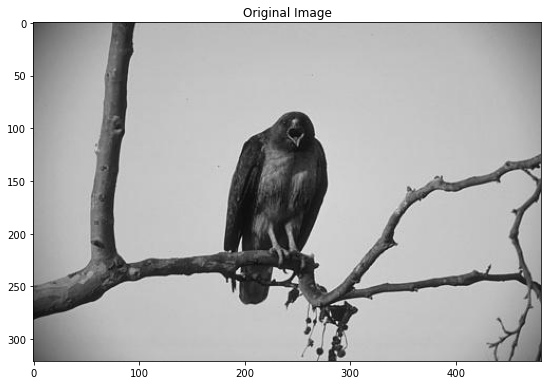

In [5]:
f = plt.figure(figsize=(20,20))
ax = f.add_subplot(221)
ax.title.set_text('Original Image')
ax.imshow(orig[:,:,::-1])

#### Storing the Image in matrix named I

In [6]:
I = np.asarray(img)
I

array([[ 81,  82,  83, ..., 105, 105, 102],
       [ 81,  81,  83, ..., 106, 105, 104],
       [ 81,  81,  83, ..., 107, 106, 105],
       ...,
       [ 82,  83,  85, ...,  35,  25,  68],
       [ 82,  82,  84, ...,  34,  24,  85],
       [ 81,  79,  81, ...,  28,  29, 100]], dtype=uint8)

#### Creating 1D Gaussian function

In [7]:
def gaussian1D(size, sigma):
    gaussian = np.zeros((size))
    size = size//2
    
    for x in range(-size, size+1): 
        x1 = np.sqrt( 2.* np.pi * sigma**2 )
        x2=np.exp(-(x**2)/(2*sigma**2))
        gaussian[[x+size]] = (1/x1)*x2
    return gaussian

#### Creating Gaussian mask G with size = 3 and Standard Deviation = 1.8

In [8]:
G = gaussian1D(3,1.8)

#### Let G1 and G2 be the Gaussian mask in X-direction and Y-direction

In [9]:
G1 = np.reshape(G, (1,3))
print('The shape of G1 is :: ', G1.shape)
print('The value of G1 is :: \n', G1)

The shape of G2 is ::  (1, 3)
The value of G2 is :: 
 [[0.18994016 0.2216346  0.18994016]]


In [10]:
G2 = np.reshape(G, (3,1))
print('The shape of G2 is :: ', G2.shape)
print('The value of G2 is :: \n', G2)

The shape of G2 is ::  (3, 1)
The value of G2 is :: 
 [[0.18994016]
 [0.2216346 ]
 [0.18994016]]


#### Creating 1D Gaussian first derivative function

In [11]:
def gaussian1DDerivative(size, sigma):
    gaussianDerivative = np.zeros((size))
    size = size//2
    
    for x in range(-size, size+1): 
        x1 = np.sqrt( 2.* np.pi * sigma**2 )
        x2=np.exp(-(x**2)/(2*sigma**2))
        p = (1/x1)*x2
        x3 = -x/(sigma**2)
        gaussianDerivative[x+size] = x3 * p
    return gaussianDerivative

#### Creating Gaussian first Derivative mask G with size = 3 and Standard Deviation = 1.8

In [12]:
GD = gaussian1DDerivative(3,1.8)

#### Let Gx and Gy be the Gaussian first Derivative mask in X-direction and Y-direction

In [13]:
Gx = np.reshape(GD, (1,3))
print('The shape of G2 is :: ', Gx.shape)
print('The value of G2 is :: \n', Gx)

The shape of G2 is ::  (1, 3)
The value of G2 is :: 
 [[ 0.05862351  0.         -0.05862351]]


In [14]:
Gy = np.reshape(GD, (3,1))
print('The shape of G2 is :: ', Gy.shape)
print('The value of G2 is :: \n', Gy)

The shape of G2 is ::  (3, 1)
The value of G2 is :: 
 [[ 0.05862351]
 [ 0.        ]
 [-0.05862351]]


#### Create own convolution function

In [15]:
def convolveImage(I, g, dim=1):
    
    if dim==1:
        k = g.shape[1]
    elif dim==0:
        k = g.shape[0]
    
    padding = int((k-1)/2) #calculate required padding to keep shape same
    orig_height, orig_width = I.shape 
    
    if dim==1:
        w = orig_width + 2*padding # calculate padded width
        I_new = np.zeros(shape=(orig_height, w), dtype=I.dtype)
        I_new[:, padding:-padding] = I
    if dim==0:
        h = orig_height + 2*padding #calculate padded height 
        I_new = np.zeros(shape=(h, orig_width), dtype=I.dtype)
        I_new[padding:-padding, :] = I
    
    g = np.flipud(np.fliplr(g)) #cross correlation
    output = np.zeros_like(I_new) 
    kx, ky = g.shape
    
    
    if dim==1:
        h = (0,I_new.shape[0])
        w = (padding,I_new.shape[1]-1-padding)
    if dim == 0:
        w = (0, I_new.shape[1])
        h = (padding,I_new.shape[0]-1-padding)
    
    for i in range(h[0], h[1]):
        for j in range(w[0], w[1]):
            if dim==1:
                output[i,j] = np.sum(np.squeeze(g, axis=0)* I_new[i, j-int(ky/2): j+int(ky/2)+1])
            if dim == 0:
                output[i,j] = np.sum(g* np.expand_dims(I_new[i-int(kx/2):i+int(kx/2)+1, j], axis=1))
                
    ## slice only original dimensions, remove padding
    if dim==1:
        output = output[:, padding:output.shape[1]-padding]
    if dim==0:
        output = output[padding:output.shape[0]-padding, :]
    return output

#### Convolve the image I with G1 along the rows to give x-component image (Ix)

In [16]:
Ix = convolveImage(I, G1, dim=1)

#### Convolve the image I with G2 along the columns to give y-component image (Iy)

In [17]:
Iy = convolveImage(I, G2,dim=0)

#### Output of images  after Convolution with I with Gaussian in x and y direction with Sigma = 1

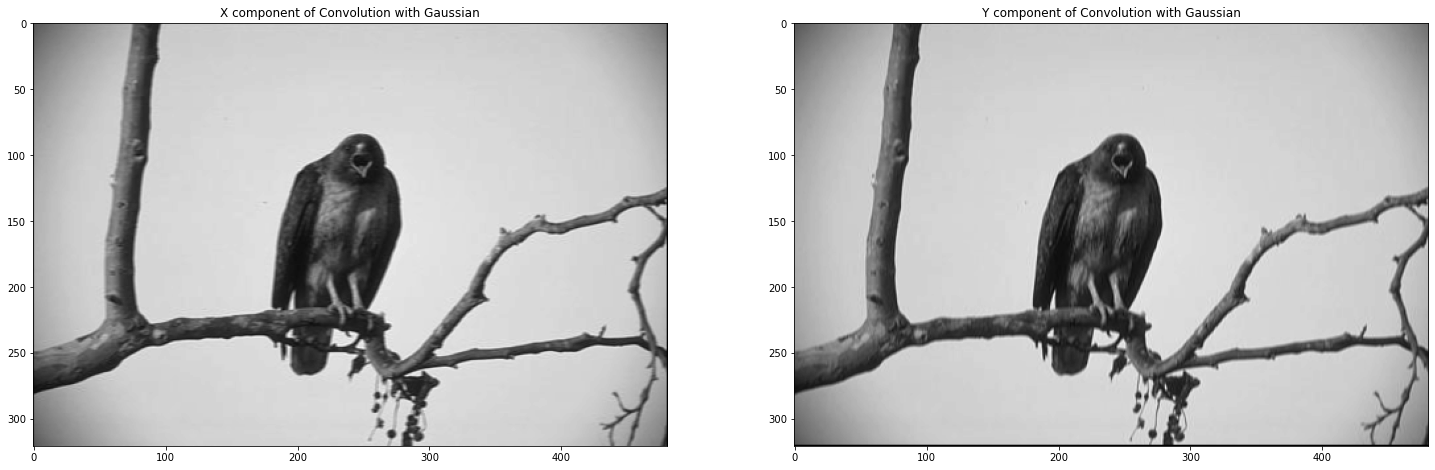

In [18]:
f = plt.figure(figsize=(25,25))
ax1 = f.add_subplot(121)
ax1.title.set_text('X component of Convolution with Gaussian')
ax1.imshow(Ix[:,:], cmap="gray")
ax2 = f.add_subplot(122)
ax2.title.set_text('Y component of Convolution with Gaussian')
ax2.imshow(Iy[:,:], cmap="gray")

#### Convolve Ix with Gx to give new_Ix, the x component of I convolved with the derivative of the Gaussian

In [19]:
new_Ix = convolveImage(Ix, Gx, dim=1)

#### Convolve Iy with Gy to give new_Iy, the y component of I convolved with the derivative of the Gaussian

In [20]:
new_Iy = convolveImage(Iy, Gy,dim=0)

#### Output of images  after Convolution with Ix and Iy with first derivative of Gaussian function

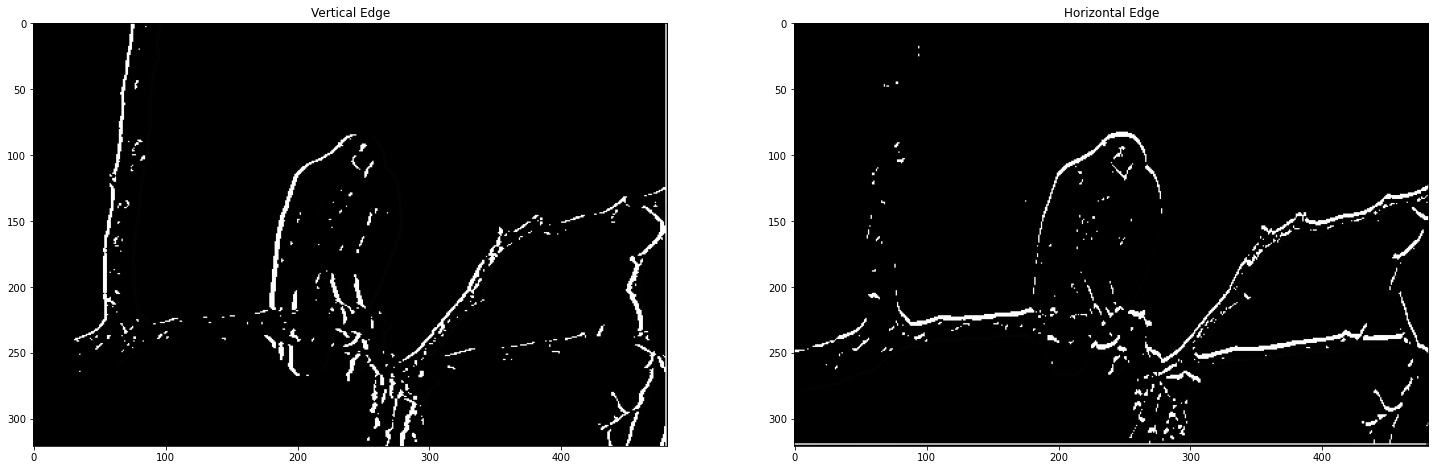

In [21]:
f = plt.figure(figsize=(25,25))
ax1 = f.add_subplot(121)
ax1.title.set_text('Vertical Edge')
ax1.imshow(new_Ix[:,:], cmap="gray")
ax2 = f.add_subplot(122)
ax2.title.set_text('Horizontal Edge')
ax2.imshow(new_Iy[:,:], cmap="gray")

#### Compute the Gradient magnitude of the edge response by combining the x and y components.

In [22]:
gradient_magnitude = np.sqrt(np.square(new_Ix) + np.square(new_Iy))
gradient_magnitude

array([[2.828, 2.   , 2.   , ..., 3.   , 4.242, 3.   ],
       [2.   , 0.   , 0.   , ..., 1.   , 3.162, 1.   ],
       [2.   , 0.   , 0.   , ..., 0.   , 3.   , 0.   ],
       ...,
       [2.   , 0.   , 0.   , ..., 0.   , 1.   , 1.   ],
       [2.828, 2.   , 2.   , ..., 1.   , 1.   , 2.   ],
       [2.   , 0.   , 0.   , ..., 0.   , 1.   , 0.   ]], dtype=float16)

In [23]:
gradient_magnitude = gradient_magnitude * 255.0 / gradient_magnitude.max()
gradient_magnitude

array([[ 99.  ,  70.06,  70.06, ..., 105.06, 148.6 , 105.06],
       [ 70.06,   0.  ,   0.  , ...,  35.03, 110.75,  35.03],
       [ 70.06,   0.  ,   0.  , ...,   0.  , 105.06,   0.  ],
       ...,
       [ 70.06,   0.  ,   0.  , ...,   0.  ,  35.03,  35.03],
       [ 99.  ,  70.06,  70.06, ...,  35.03,  35.03,  70.06],
       [ 70.06,   0.  ,   0.  , ...,   0.  ,  35.03,   0.  ]],
      dtype=float16)

#### Compute Gradient Direction

In [24]:
gradient_direction =(np.arctan2(new_Iy,new_Ix))
gradient_direction

array([[0.785   , 1.57    , 1.57    , ..., 1.57    , 0.011856, 1.57    ],
       [0.      , 0.      , 0.      , ..., 1.57    , 0.003952, 1.57    ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 1.57    ],
       [1.5625  , 1.57    , 1.57    , ..., 1.57    , 0.      , 1.57    ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]],
      dtype=float16)

#### Converting Gradient direction from radian to degree 

In [25]:
gradient_direction = np.rad2deg(gradient_direction)

#### Implementing non-maximum suppression

In [26]:
def non_max_suppression(gradient_magnitude, gradient_direction):
    image_row, image_col = gradient_magnitude.shape
 
    output = np.zeros(gradient_magnitude.shape)
 
    PI = 180
 
    for row in range(1, image_row - 1):
        for col in range(1, image_col - 1):
            direction = gradient_direction[row, col]
 
            if (0 <= direction < PI / 4) or (PI <= direction <= 5 * PI / 4):
                before_pixel = gradient_magnitude[row, col - 1]
                after_pixel = gradient_magnitude[row, col + 1]
 
            elif (PI / 4 <= direction <  PI / 2) or (5 * PI / 4 <= direction < 3 * PI / 2):
                before_pixel = gradient_magnitude[row + 1, col - 1]
                after_pixel = gradient_magnitude[row - 1, col + 1]
 
            elif ( PI / 2 <= direction < 6 * PI / 8) or (3 * PI / 2 <= direction < 7 * PI / 4):
                before_pixel = gradient_magnitude[row - 1, col]
                after_pixel = gradient_magnitude[row + 1, col]
 
            else:
                before_pixel = gradient_magnitude[row - 1, col - 1]
                after_pixel = gradient_magnitude[row + 1, col + 1]
 
          
            if gradient_magnitude[row, col] >= before_pixel and gradient_magnitude[row, col] >= after_pixel:
                output[row, col] = gradient_magnitude[row, col]
 
    return output
 

#### Applying non_max_suppression on gradient_magnitude and gradient_direction

In [27]:
new_non_max_suppression_Image = non_max_suppression(gradient_magnitude, gradient_direction)

#### Comparing Gradient magnitude vs after Non-Max suppression 

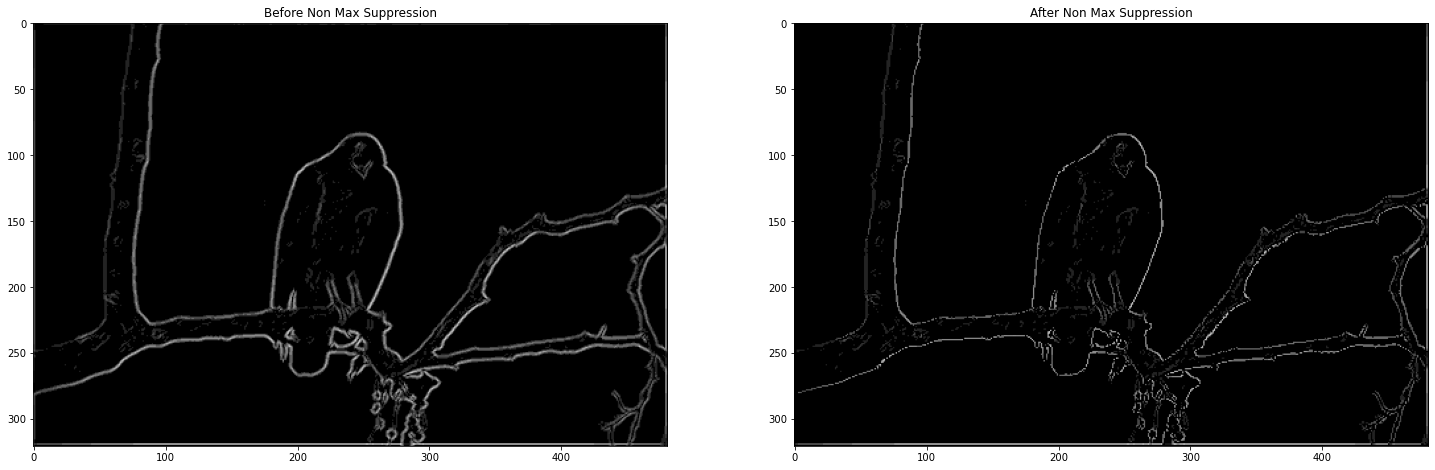

In [28]:
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(121)
data = np.array(gradient_magnitude, dtype=np.float32)
ax.title.set_text('Before Non Max Suppression')
ax.imshow(data, cmap="gray")
ax2 = f.add_subplot(122)
data = np.array(new_non_max_suppression_Image, dtype=np.float32)
ax2.title.set_text('After Non Max Suppression')
ax2.imshow(data, cmap="gray")

#### Defining low limit and upper limit threshold

In [29]:
def threshold(image, low, high, weak):
    output = np.zeros(image.shape)
 
    strong = 255
 
    strong_row, strong_col = np.where(image >= high)
    weak_row, weak_col = np.where((image <= high) & (image >= low))
 
    output[strong_row, strong_col] = strong
    output[weak_row, weak_col] = weak
 
    return output

#### Creating Hysteresis function

In [30]:
def hysteresis(image, weak):
    image_row, image_col = image.shape
 
    top_to_bottom = image.copy()
 
    for row in range(1, image_row):
        for col in range(1, image_col):
            if top_to_bottom[row, col] == weak:
                if top_to_bottom[row, col + 1] == 255 or top_to_bottom[row, col - 1] == 255 or top_to_bottom[row - 1, col] == 255 or top_to_bottom[
                    row + 1, col] == 255 or top_to_bottom[
                    row - 1, col - 1] == 255 or top_to_bottom[row + 1, col - 1] == 255 or top_to_bottom[row - 1, col + 1] == 255 or top_to_bottom[
                    row + 1, col + 1] == 255:
                    top_to_bottom[row, col] = 255
                else:
                    top_to_bottom[row, col] = 0
 
    bottom_to_top = image.copy()
 
    for row in range(image_row - 1, 0, -1):
        for col in range(image_col - 1, 0, -1):
            if bottom_to_top[row, col] == weak:
                if bottom_to_top[row, col + 1] == 255 or bottom_to_top[row, col - 1] == 255 or bottom_to_top[row - 1, col] == 255 or bottom_to_top[
                    row + 1, col] == 255 or bottom_to_top[
                    row - 1, col - 1] == 255 or bottom_to_top[row + 1, col - 1] == 255 or bottom_to_top[row - 1, col + 1] == 255 or bottom_to_top[
                    row + 1, col + 1] == 255:
                    bottom_to_top[row, col] = 255
                else:
                    bottom_to_top[row, col] = 0
 
    right_to_left = image.copy()
 
    for row in range(1, image_row):
        for col in range(image_col - 1, 0, -1):
            if right_to_left[row, col] == weak:
                if right_to_left[row, col + 1] == 255 or right_to_left[row, col - 1] == 255 or right_to_left[row - 1, col] == 255 or right_to_left[
                    row + 1, col] == 255 or right_to_left[
                    row - 1, col - 1] == 255 or right_to_left[row + 1, col - 1] == 255 or right_to_left[row - 1, col + 1] == 255 or right_to_left[
                    row + 1, col + 1] == 255:
                    right_to_left[row, col] = 255
                else:
                    right_to_left[row, col] = 0
 
    left_to_right = image.copy()
 
    for row in range(image_row - 1, 0, -1):
        for col in range(1, image_col):
            if left_to_right[row, col] == weak:
                if left_to_right[row, col + 1] == 255 or left_to_right[row, col - 1] == 255 or left_to_right[row - 1, col] == 255 or left_to_right[
                    row + 1, col] == 255 or left_to_right[
                    row - 1, col - 1] == 255 or left_to_right[row + 1, col - 1] == 255 or left_to_right[row - 1, col + 1] == 255 or left_to_right[
                    row + 1, col + 1] == 255:
                    left_to_right[row, col] = 255
                else:
                    left_to_right[row, col] = 0
 
    final_image = top_to_bottom + bottom_to_top + right_to_left + left_to_right
 
    final_image[final_image > 255] = 255
 
    return final_image

#### Applying Hysteresis thresholding to obtain final edge-map

In [31]:
weak = 75
new_image = threshold(new_non_max_suppression_Image, 10, 80, weak=weak)
new_image = hysteresis(new_non_max_suppression_Image, weak)

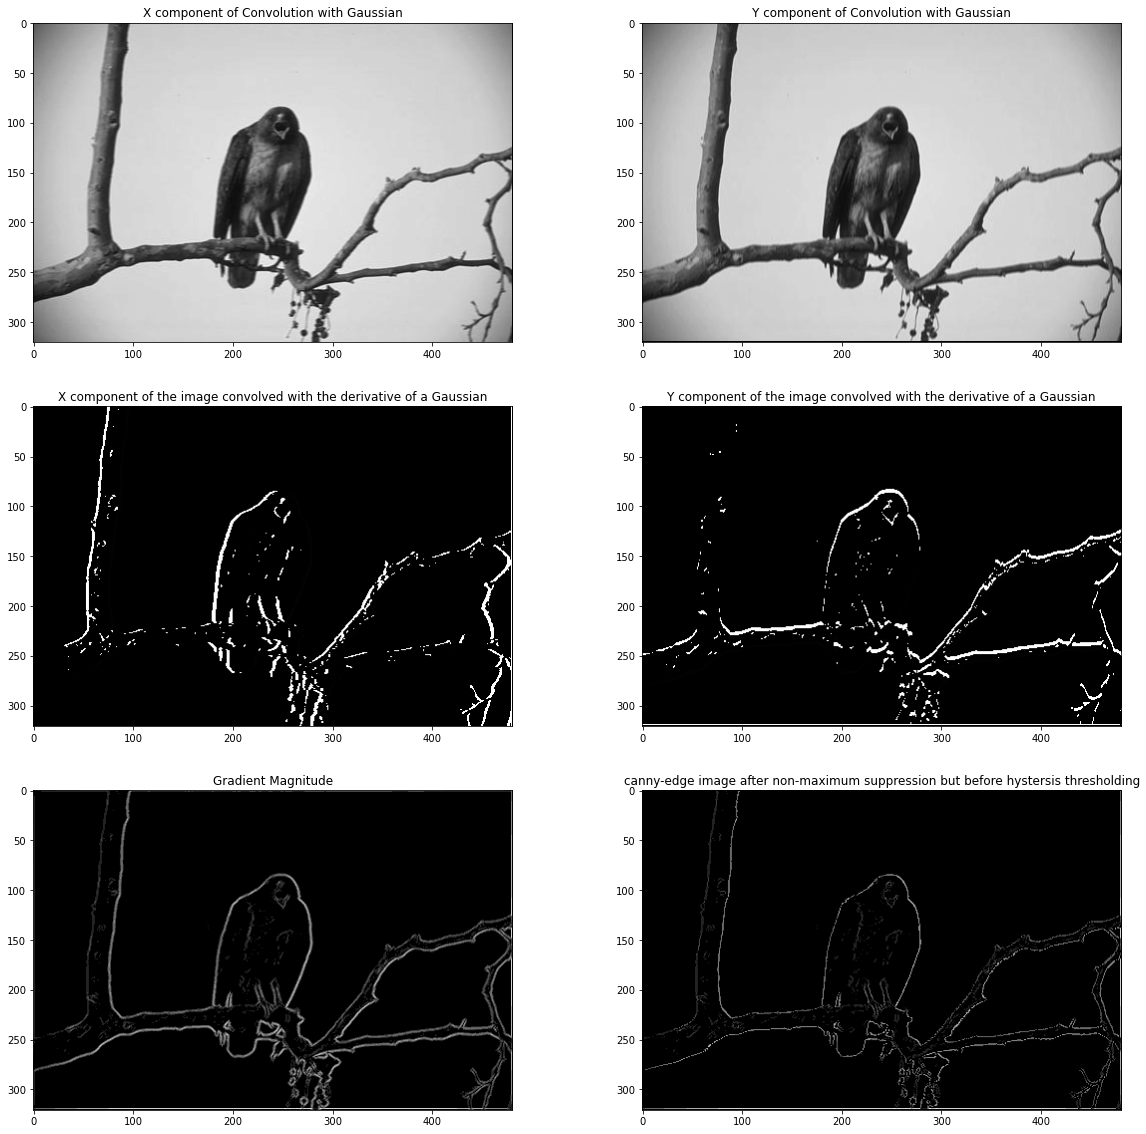

In [32]:
f = plt.figure(figsize=(20,20))
ax = f.add_subplot(321)
data = np.array(Ix, dtype=np.float32)
ax.title.set_text('X component of Convolution with Gaussian')
ax.imshow(data, cmap="gray")
ax2 = f.add_subplot(322)
data = np.array(Iy, dtype=np.float32)
ax2.title.set_text('Y component of Convolution with Gaussian')
ax2.imshow(data, cmap="gray")
ax3 = f.add_subplot(323)
data = np.array(new_Ix, dtype=np.float32)
ax3.title.set_text('X component of the image convolved with the derivative of a Gaussian')
ax3.imshow(data, cmap="gray")
ax4 = f.add_subplot(324)
data = np.array(new_Iy, dtype=np.float32)
ax4.title.set_text('Y component of the image convolved with the derivative of a Gaussian')
ax4.imshow(data, cmap="gray")
ax5 = f.add_subplot(325)
data = np.array(gradient_magnitude, dtype=np.float32)
ax5.title.set_text('Gradient Magnitude')
ax5.imshow(data, cmap="gray")
ax6 = f.add_subplot(326)
data = np.array(new_non_max_suppression_Image, dtype=np.float32)
ax6.title.set_text('canny-edge image after non-maximum suppression but before hystersis thresholding')
ax6.imshow(data, cmap="gray")

#### Output image -- Manual Created Canny Detection

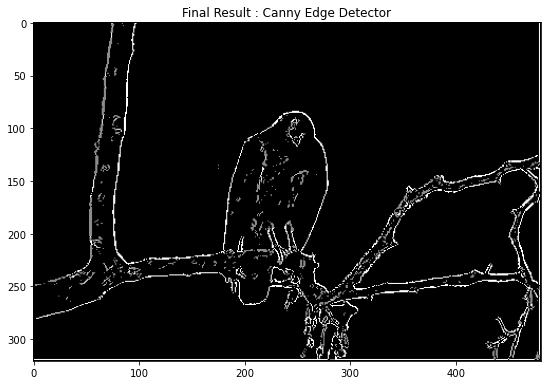

In [33]:
f = plt.figure(figsize=(20,20))
ax = f.add_subplot(121)
data = np.array(new_image, dtype=np.float32)

ax.title.set_text('Final Result : Canny Edge Detector')
ax.imshow(data, cmap="gray")

# Uploading the second image

In [34]:
orig = cv2.imread('Image2.jpg')

#### Converting the Image into Gray Channel

In [35]:
if len(orig.shape) == 3:
    print("Found 3 Channels : {}".format(orig.shape))
    img = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
    print("Converted to Gray Channel. Size : {}".format(img.shape))
else:
    img = orig
    print("Image Shape : {}".format(img.shape))

Found 3 Channels : (321, 481, 3)
Converted to Gray Channel. Size : (321, 481)


#### Output of original image

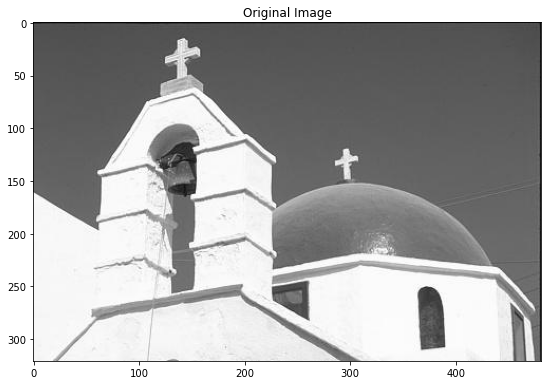

In [36]:
f = plt.figure(figsize=(20,20))
ax = f.add_subplot(221)
ax.title.set_text('Original Image')
ax.imshow(orig[:,:,::-1])

#### Storing the Image in matrix named I

In [37]:
I = np.asarray(img)
I

array([[ 29,  29,  29, ...,  35,  18,  13],
       [ 51,  51,  51, ...,  73,  58,  13],
       [ 83,  83,  83, ...,  79,  66,  14],
       ...,
       [244, 245, 246, ..., 113, 108,  31],
       [244, 245, 246, ..., 110, 109,  32],
       [245, 245, 245, ..., 112, 111,  34]], dtype=uint8)

#### Convolve the image I with G1 along the rows to give x-component image (Ix)

In [38]:
Ix = convolveImage(I, G1, dim=1)
Ix

array([[ 11,  17,  17, ...,  18,  13,   0],
       [ 20,  30,  30, ...,  42,  29,   0],
       [ 34,  49,  49, ...,  45,  32,   0],
       ...,
       [100, 147, 147, ...,  66,  51,   0],
       [100, 147, 147, ...,  64,  51,   0],
       [100, 147, 147, ...,  67,  52,   0]], dtype=uint8)

#### Convolve the image I with G2 along the columns to give y-component image (Iy)

In [39]:
Iy = convolveImage(I, G2,dim=0)
Iy

array([[ 16,  16,  16, ...,  21,  15,   5],
       [ 32,  32,  32, ...,  37,  28,   8],
       [ 43,  43,  43, ...,  46,  38,   8],
       ...,
       [146, 147, 147, ...,  67,  64,  18],
       [146, 147, 147, ...,  67,  65,  19],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

#### Output of images  after Convolution with Ix and Iy with first derivative of Gaussian function

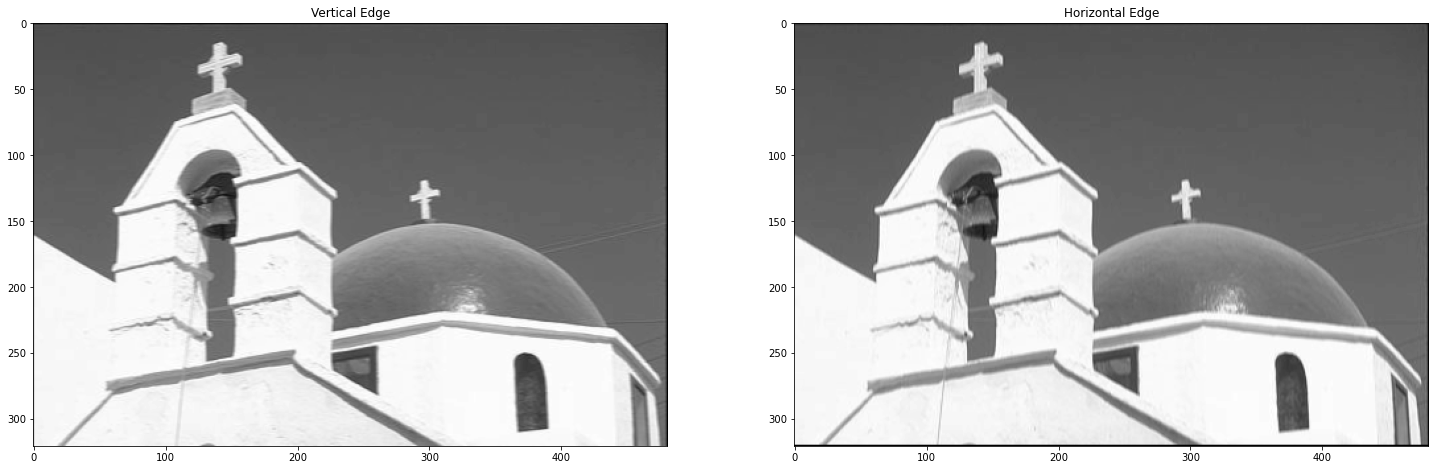

In [40]:
f = plt.figure(figsize=(25,25))
ax1 = f.add_subplot(121)
ax1.title.set_text('Vertical Edge')
ax1.imshow(Ix[:,:], cmap="gray")
ax2 = f.add_subplot(122)
ax2.title.set_text('Horizontal Edge')
ax2.imshow(Iy[:,:], cmap="gray")

#### Convolve Ix with Gx to give new_Ix, the x component of I convolved with the derivative of the Gaussian

In [41]:
new_Ix = convolveImage(Ix, Gx, dim=1)
new_Ix

array([[  0,   0,   0, ...,   0, 255,   0],
       [  1,   0,   0, ...,   0, 254,   0],
       [  2,   0,   0, ...,   0, 254,   0],
       ...,
       [  8,   2,   0, ...,   0, 253,   0],
       [  8,   2,   0, ...,   0, 253,   0],
       [  8,   2,   0, ...,   0, 253,   0]], dtype=uint8)

#### Convolve Iy with Gy to give new_Iy, the y component of I convolved with the derivative of the Gaussian

In [42]:
new_Iy = convolveImage(Iy, Gy,dim=0)
new_Iy

array([[  1,   1,   1, ...,   2,   1,   0],
       [  1,   1,   1, ...,   1,   1,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [248, 248, 248, ..., 253, 253, 255],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

#### Output of images  after Convolution with Ix and Iy with first derivative of Gaussian function

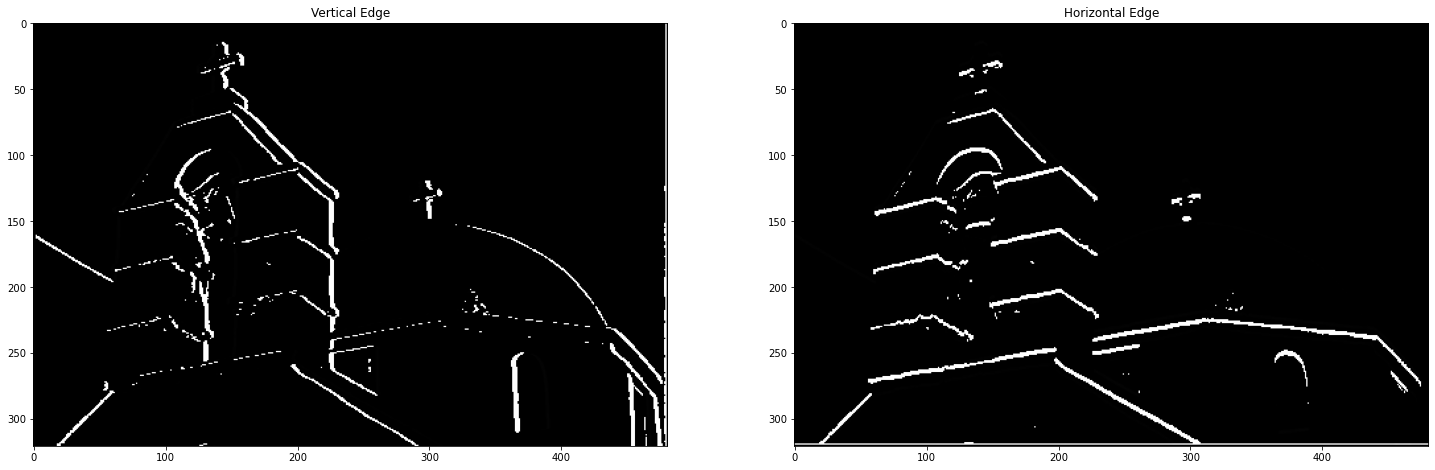

In [43]:
f = plt.figure(figsize=(25,25))
ax1 = f.add_subplot(121)
ax1.title.set_text('Vertical Edge')
ax1.imshow(new_Ix[:,:], cmap="gray")
ax2 = f.add_subplot(122)
ax2.title.set_text('Horizontal Edge')
ax2.imshow(new_Iy[:,:], cmap="gray")

#### Compute the Gradient magnitude of the edge response by combining the x and y components.

In [44]:
gradient_magnitude = np.sqrt(np.square(new_Ix) + np.square(new_Iy))
gradient_magnitude

array([[ 1.   ,  1.   ,  1.   , ...,  2.   ,  1.414,  0.   ],
       [ 1.414,  1.   ,  1.   , ...,  1.   ,  2.236,  0.   ],
       [ 2.   ,  0.   ,  0.   , ...,  0.   ,  2.   ,  0.   ],
       ...,
       [ 8.   ,  2.   ,  0.   , ...,  0.   ,  3.   ,  0.   ],
       [11.31 ,  8.25 ,  8.   , ...,  3.   ,  4.242,  1.   ],
       [ 8.   ,  2.   ,  0.   , ...,  0.   ,  3.   ,  0.   ]],
      dtype=float16)

In [45]:
gradient_magnitude = gradient_magnitude * 255.0 / gradient_magnitude.max()
gradient_magnitude

array([[ 22.55,  22.55,  22.55, ...,  45.1 ,  31.88,   0.  ],
       [ 31.88,  22.55,  22.55, ...,  22.55,  50.44,   0.  ],
       [ 45.1 ,   0.  ,   0.  , ...,   0.  ,  45.1 ,   0.  ],
       ...,
       [180.4 ,  45.1 ,   0.  , ...,   0.  ,  67.6 ,   0.  ],
       [255.  , 186.  , 180.4 , ...,  67.6 ,  95.6 ,  22.55],
       [180.4 ,  45.1 ,   0.  , ...,   0.  ,  67.6 ,   0.  ]],
      dtype=float16)

#### Compute Gradient Direction

In [46]:
gradient_direction =(np.arctan2(new_Iy,new_Ix))
gradient_direction

array([[1.57    , 1.57    , 1.57    , ..., 1.57    , 0.00392 , 0.      ],
       [0.785   , 1.57    , 1.57    , ..., 1.57    , 0.003937, 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [1.538   , 1.5625  , 1.57    , ..., 1.57    , 0.785   , 1.57    ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]],
      dtype=float16)

#### Converting Gradient direction from radian to degree 

In [47]:
gradient_direction = np.rad2deg(gradient_direction)
gradient_direction

array([[90.    , 90.    , 90.    , ..., 90.    ,  0.2247,  0.    ],
       [45.    , 90.    , 90.    , ..., 90.    ,  0.2256,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       ...,
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [88.1   , 89.5   , 90.    , ..., 90.    , 45.    , 90.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ]],
      dtype=float16)

#### Applying non_max_suppression on gradient_magnitude and gradient_direction

In [48]:
new_non_max_suppression_Image = non_max_suppression(gradient_magnitude, gradient_direction)

#### Comparing Gradient magnitude vs after Non-Max suppression 

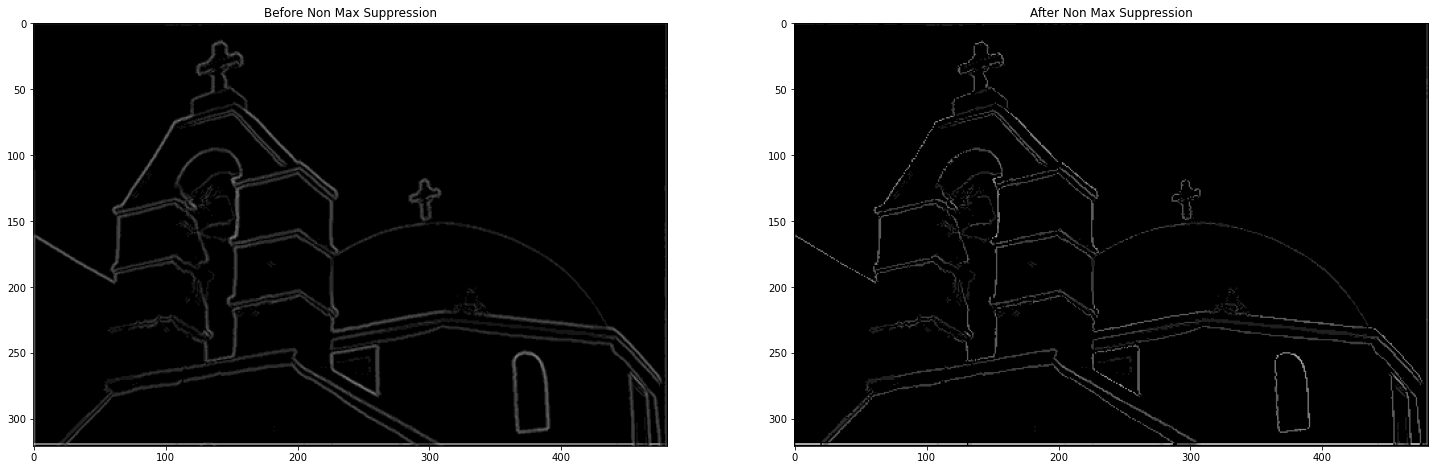

In [49]:
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(121)
data = np.array(gradient_magnitude, dtype=np.float32)
ax.title.set_text('Before Non Max Suppression')
ax.imshow(data, cmap="gray")
ax2 = f.add_subplot(122)
data = np.array(new_non_max_suppression_Image, dtype=np.float32)
ax2.title.set_text('After Non Max Suppression')
ax2.imshow(data, cmap="gray")

#### Applying Hysteresis thresholding to obtain final edge-map

In [50]:
weak = 50
new_image = threshold(new_non_max_suppression_Image, 25, 150, weak=weak)
new_image = hysteresis(new_non_max_suppression_Image, weak)

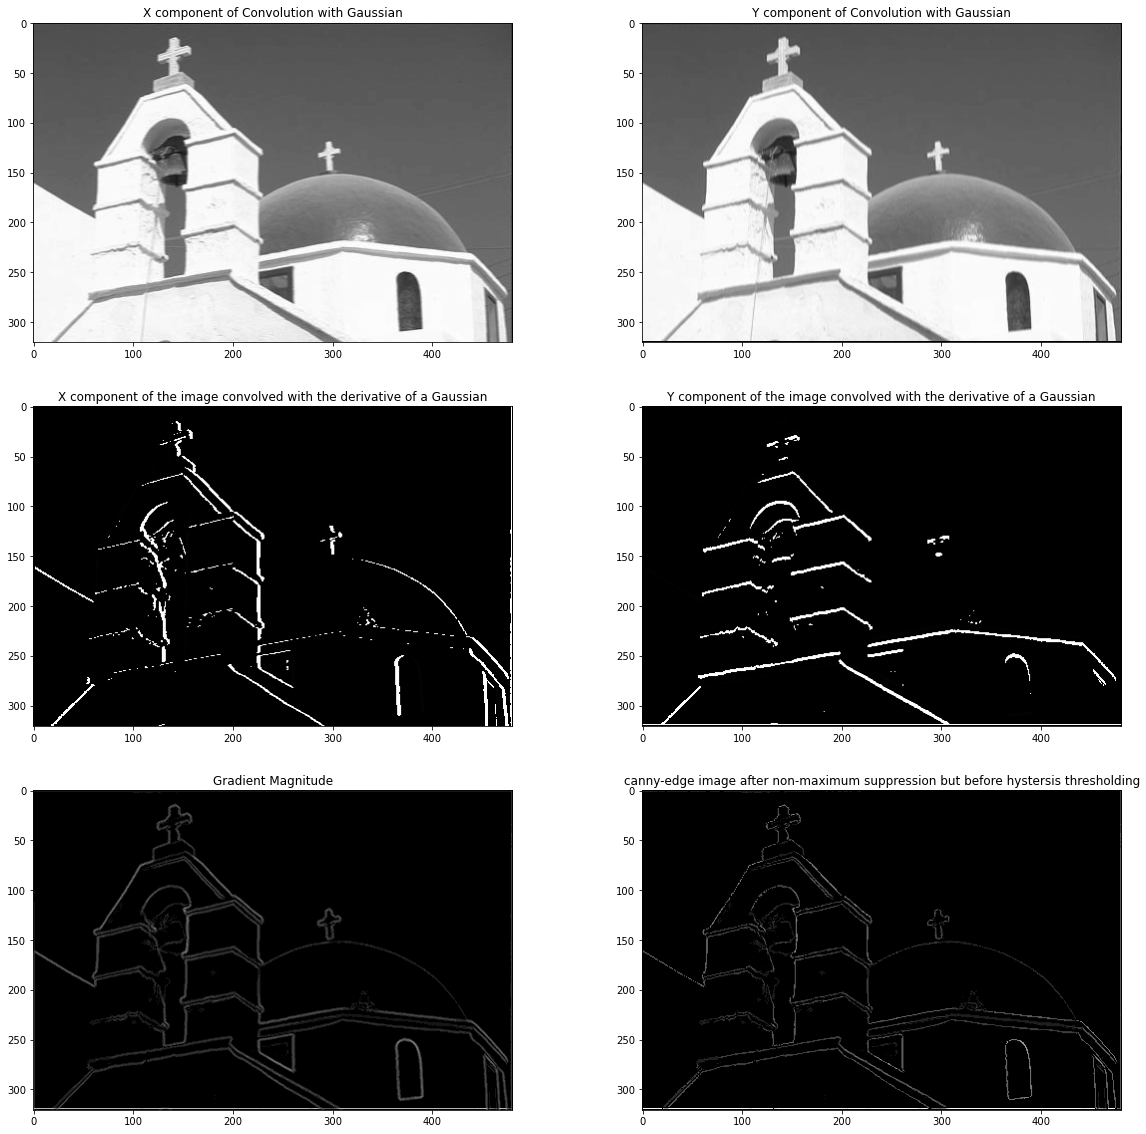

In [51]:
f = plt.figure(figsize=(20,20))
ax = f.add_subplot(321)
ax.title.set_text('X component of Convolution with Gaussian')
ax.imshow(Ix[:,:], cmap="gray")
ax2 = f.add_subplot(322)
ax2.title.set_text('Y component of Convolution with Gaussian')
ax2.imshow(Iy[:,:], cmap="gray")
ax3 = f.add_subplot(323)
ax3.title.set_text('X component of the image convolved with the derivative of a Gaussian')
ax3.imshow(new_Ix[:,:], cmap="gray")
ax4 = f.add_subplot(324)
ax4.title.set_text('Y component of the image convolved with the derivative of a Gaussian')
ax4.imshow(new_Iy[:,:], cmap="gray")
ax5 = f.add_subplot(325)
data = np.array(gradient_magnitude, dtype=np.float32)
ax5.title.set_text('Gradient Magnitude')
ax5.imshow(data, cmap="gray")
ax6 = f.add_subplot(326)
data = np.array(new_non_max_suppression_Image, dtype=np.float32)
ax6.title.set_text('canny-edge image after non-maximum suppression but before hystersis thresholding')
ax6.imshow(data, cmap="gray")

#### Output image -- Manual Created Canny Detection

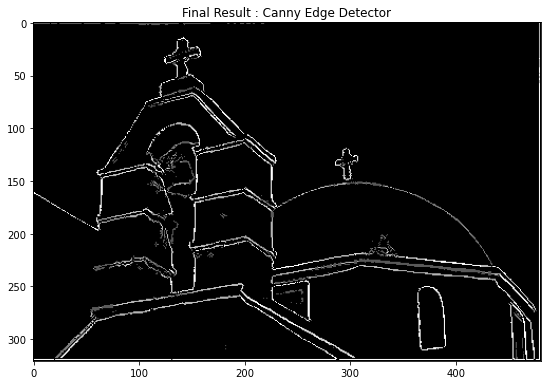

In [52]:
f = plt.figure(figsize=(20,20))
ax = f.add_subplot(121)
data = np.array(new_image, dtype=np.float32)
ax.title.set_text('Final Result : Canny Edge Detector')
ax.imshow(data, cmap="gray")

# Uploading the third image 

In [53]:
orig = cv2.imread('Image3.jpg')

#### Converting the Image into Gray Channel

In [54]:
if len(orig.shape) == 3:
    print("Found 3 Channels : {}".format(orig.shape))
    img = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
    print("Converted to Gray Channel. Size : {}".format(img.shape))
else:
    img = orig
    print("Image Shape : {}".format(img.shape))

Found 3 Channels : (481, 321, 3)
Converted to Gray Channel. Size : (481, 321)


#### Output of original image

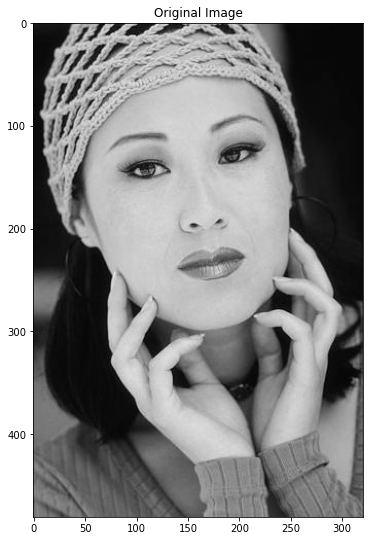

In [55]:
f = plt.figure(figsize=(20,20))
ax = f.add_subplot(221)
ax.title.set_text('Original Image')
ax.imshow(orig[:,:,::-1])

#### Storing the Image in matrix named I

In [56]:
I = np.asarray(img)
I

array([[ 29,  29,  29, ...,   7,   7,   7],
       [ 27,  27,  27, ...,   7,   7,   7],
       [ 25,  25,  25, ...,   7,   7,   7],
       ...,
       [123, 114, 115, ..., 100, 113,  98],
       [123, 114, 114, ..., 108, 106,  94],
       [120, 118, 119, ..., 107, 117,  93]], dtype=uint8)

#### Convolve the image I with G1 along the rows to give x-component image (Ix)

In [57]:
Ix = convolveImage(I, G1, dim=1)
Ix

array([[11, 17, 17, ...,  4,  4,  0],
       [11, 16, 16, ...,  4,  4,  0],
       [10, 15, 14, ...,  4,  4,  0],
       ...,
       [48, 70, 71, ..., 63, 62,  0],
       [48, 70, 70, ..., 66, 61,  0],
       [49, 71, 72, ..., 66, 63,  0]], dtype=uint8)

#### Convolve the image I with G2 along the columns to give y-component image (Iy)

In [58]:
Iy = convolveImage(I, G2,dim=0)
Iy

array([[11, 11, 11, ...,  2,  2,  2],
       [16, 16, 16, ...,  4,  4,  4],
       [15, 15, 15, ...,  4,  4,  4],
       ...,
       [73, 68, 69, ..., 61, 68, 60],
       [73, 69, 69, ..., 63, 67, 57],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

#### Output of images  after Convolution with Ix and Iy with first derivative of Gaussian function

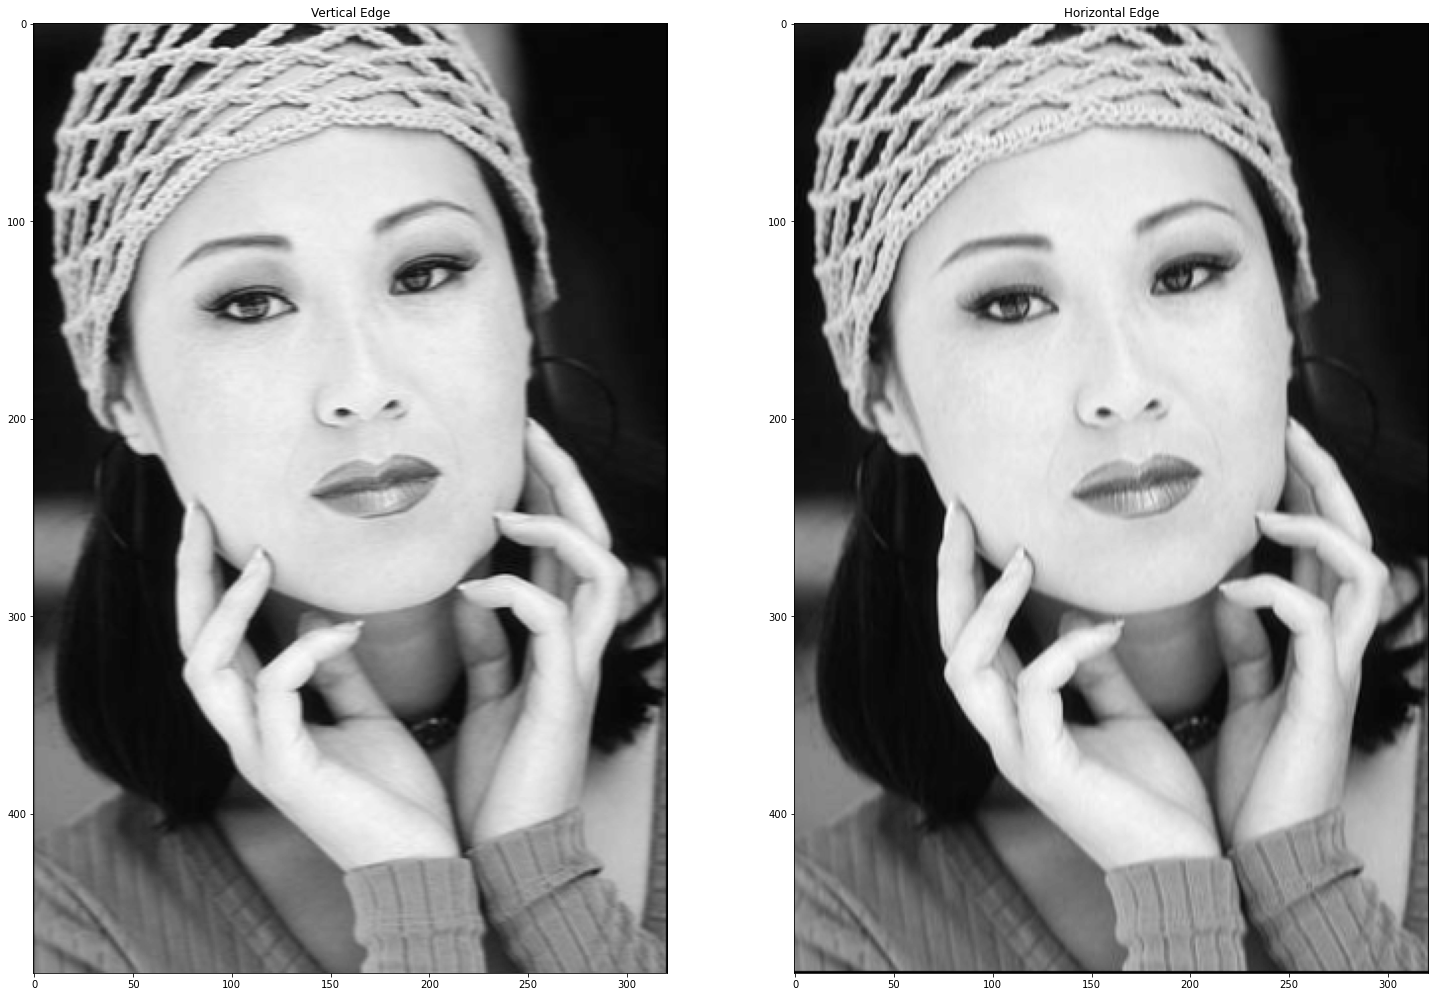

In [59]:
f = plt.figure(figsize=(25,25))
ax1 = f.add_subplot(121)
ax1.title.set_text('Vertical Edge')
ax1.imshow(Ix[:,:], cmap="gray")
ax2 = f.add_subplot(122)
ax2.title.set_text('Horizontal Edge')
ax2.imshow(Iy[:,:], cmap="gray")

#### Convolve Ix with Gx to give new_Ix, the x component of I convolved with the derivative of the Gaussian

In [60]:
new_Ix = convolveImage(Ix, Gx, dim=1)
new_Ix

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  4,   1,   0, ...,   0, 253,   0],
       [  4,   1,   0, ...,   0, 253,   0],
       [  4,   1,   0, ...,   0, 253,   0]], dtype=uint8)

#### Convolve Iy with Gy to give new_Iy, the y component of I convolved with the derivative of the Gaussian

In [61]:
new_Iy = convolveImage(Iy, Gy,dim=0)
new_Iy

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [252, 253, 252, ..., 253, 253, 253],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

#### Output of images  after Convolution with Ix and Iy with first derivative of Gaussian function

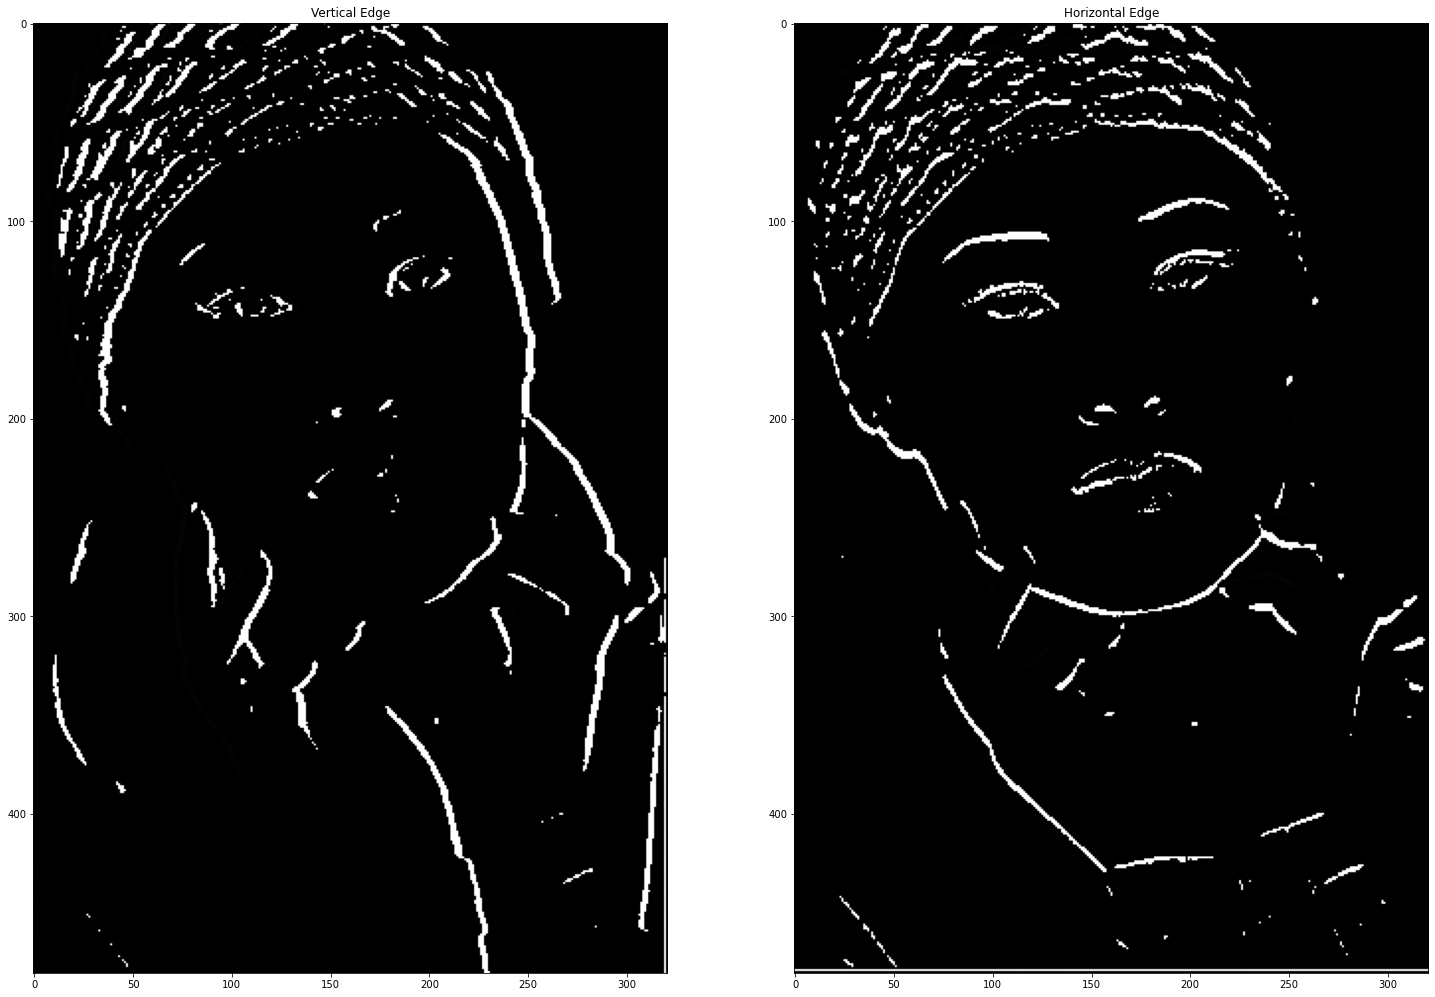

In [62]:
f = plt.figure(figsize=(25,25))
ax1 = f.add_subplot(121)
ax1.title.set_text('Vertical Edge')
ax1.imshow(new_Ix[:,:], cmap="gray")
ax2 = f.add_subplot(122)
ax2.title.set_text('Horizontal Edge')
ax2.imshow(new_Iy[:,:], cmap="gray")

#### Compute the Gradient magnitude of the edge response by combining the x and y components.

In [63]:
gradient_magnitude = np.sqrt(np.square(new_Ix) + np.square(new_Iy))
gradient_magnitude

array([[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [4.   , 1.   , 0.   , ..., 0.   , 3.   , 0.   ],
       [5.656, 3.162, 4.   , ..., 3.   , 4.242, 3.   ],
       [4.   , 1.   , 0.   , ..., 0.   , 3.   , 0.   ]], dtype=float16)

In [64]:
gradient_magnitude = gradient_magnitude * 255.0 / gradient_magnitude.max()
gradient_magnitude

array([[  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       ...,
       [133.9 ,  33.47,   0.  , ...,   0.  , 100.44,   0.  ],
       [189.2 , 105.9 , 133.9 , ..., 100.44, 142.  , 100.44],
       [133.9 ,  33.47,   0.  , ...,   0.  , 100.44,   0.  ]],
      dtype=float16)

#### Compute Gradient Direction

In [65]:
gradient_direction =(np.arctan2(new_Iy,new_Ix))
gradient_direction

array([[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [1.555, 1.566, 1.57 , ..., 1.57 , 0.785, 1.57 ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]], dtype=float16)

#### Converting Gradient direction from radian to degree 

In [66]:
gradient_direction = np.rad2deg(gradient_direction)
gradient_direction

array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [89.06, 89.75, 90.  , ..., 90.  , 45.  , 90.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ]], dtype=float16)

#### Applying non_max_suppression on gradient_magnitude and gradient_direction

In [67]:
new_non_max_suppression_Image = non_max_suppression(gradient_magnitude, gradient_direction)

#### Comparing Gradient magnitude vs after Non-Max suppression 

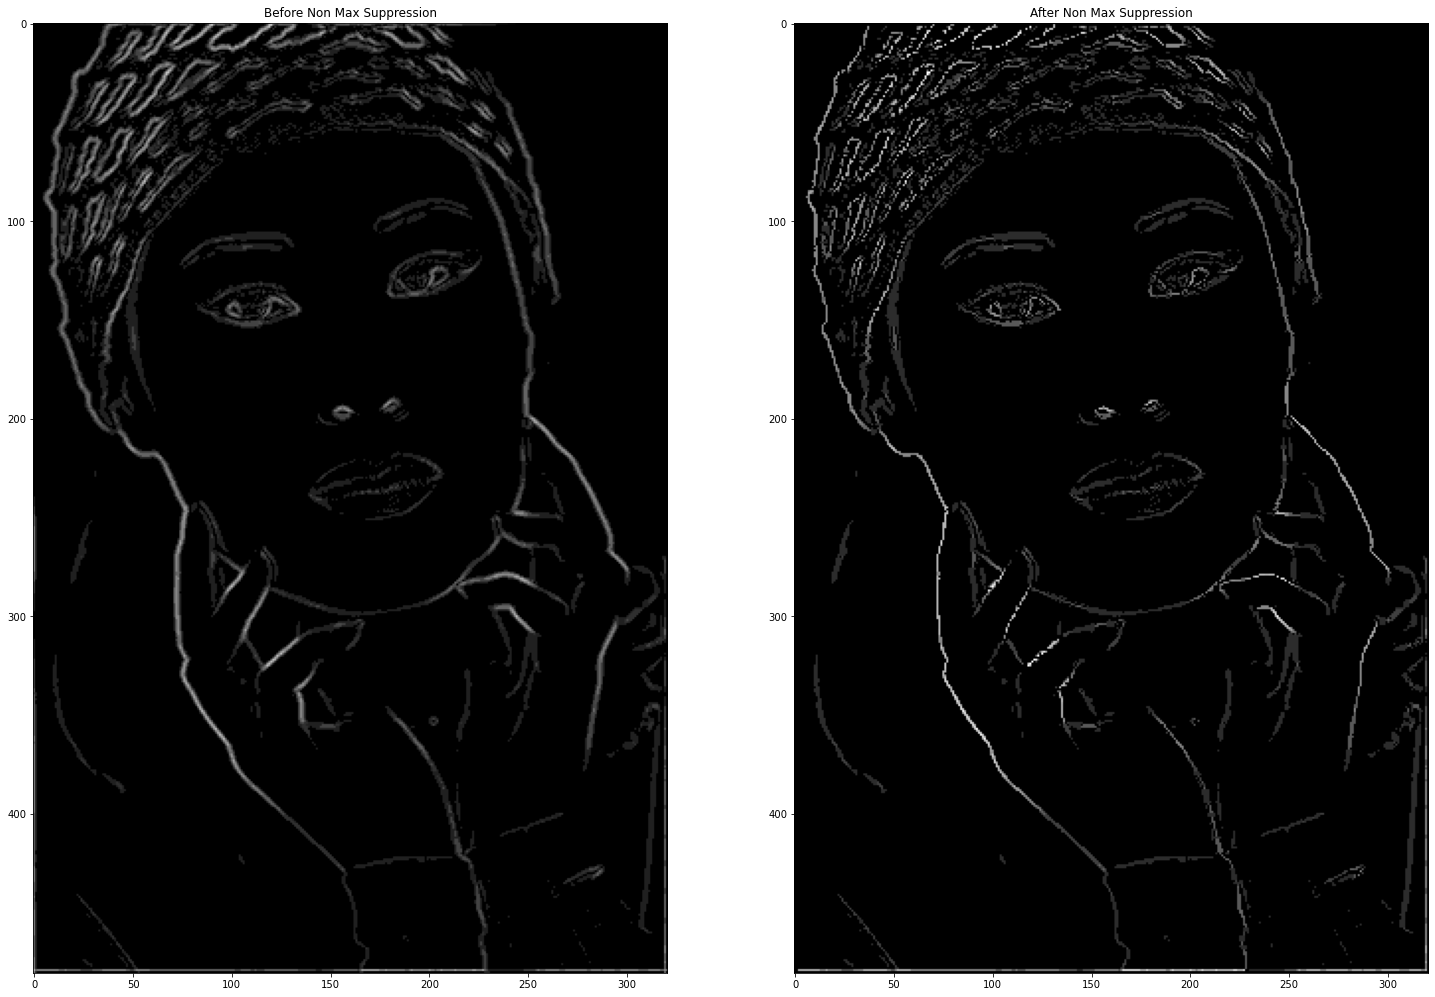

In [68]:
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(121)
data = np.array(gradient_magnitude, dtype=np.float32)
ax.title.set_text('Before Non Max Suppression')
ax.imshow(data, cmap="gray")
ax2 = f.add_subplot(122)
data = np.array(new_non_max_suppression_Image, dtype=np.float32)
ax2.title.set_text('After Non Max Suppression')
ax2.imshow(data, cmap="gray")

#### Applying Hysteresis thresholding to obtain final edge-map

In [69]:
weak = 50
new_image = threshold(new_non_max_suppression_Image, 20, 120, weak=weak)
new_image = hysteresis(new_non_max_suppression_Image, weak)

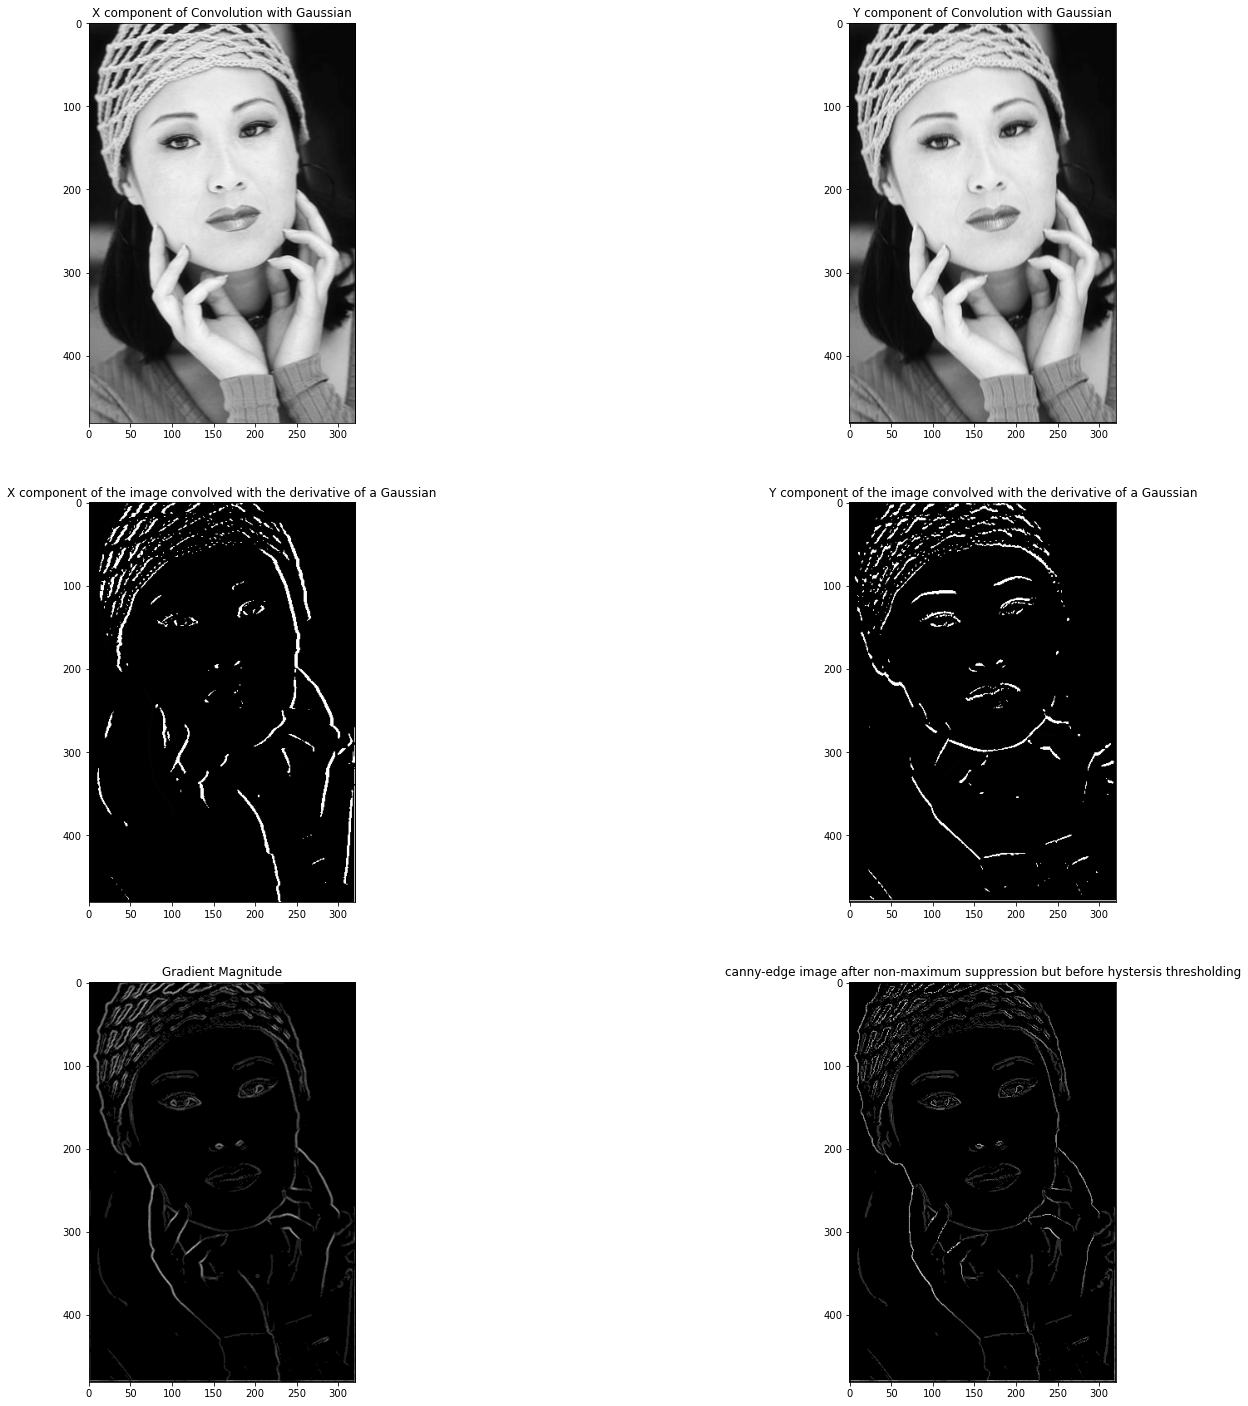

In [70]:
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(321)
ax.title.set_text('X component of Convolution with Gaussian')
ax.imshow(Ix[:,:], cmap="gray")
ax2 = f.add_subplot(322)
ax2.title.set_text('Y component of Convolution with Gaussian')
ax2.imshow(Iy[:,:], cmap="gray")
ax3 = f.add_subplot(323)
ax3.title.set_text('X component of the image convolved with the derivative of a Gaussian')
ax3.imshow(new_Ix[:,:], cmap="gray")
ax4 = f.add_subplot(324)
ax4.title.set_text('Y component of the image convolved with the derivative of a Gaussian')
ax4.imshow(new_Iy[:,:], cmap="gray")
ax5 = f.add_subplot(325)
data = np.array(gradient_magnitude, dtype=np.float32)
ax5.title.set_text('Gradient Magnitude')
ax5.imshow(data, cmap="gray")
ax6 = f.add_subplot(326)
data = np.array(new_non_max_suppression_Image, dtype=np.float32)
ax6.title.set_text('canny-edge image after non-maximum suppression but before hystersis thresholding')
ax6.imshow(data, cmap="gray")

#### Output image -- Manual Created Canny Detection

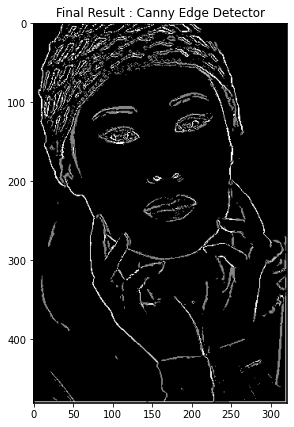

In [71]:
f = plt.figure(figsize=(10,20))
ax = f.add_subplot(121)
data = np.array(new_image, dtype=np.float32)
ax.title.set_text('Final Result : Canny Edge Detector')
ax.imshow(data, cmap="gray")